In [1]:
#Required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Rescaling
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import os
os.environ['KAGGLE_USERNAME']="XXXXXX"
os.environ['KAGGLE_KEY']="XXXXXX"
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

100% 474M/474M [00:07<00:00, 83.2MB/s]
100% 474M/474M [00:07<00:00, 64.2MB/s]


In [3]:
import zipfile
import os

# Specify the path to the uploaded zip file
zip_file_path = '/content/muffin-vs-chihuahua-image-classification.zip'  # Change this to your actual file path

# Specify the directory where you want to extract the contents
extraction_path = '/content/muffin-vs-chihuahua-image-classification/'  # Change this to your desired extraction path

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [4]:
image_size=(224,224)
batch_size=32
color_mode='rgb'

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/muffin-vs-chihuahua-image-classification/train/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/muffin-vs-chihuahua-image-classification/test/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [5]:
# Extract image and label arrays from train set
X_train, y_train=[], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train=np.array(X_train)
y_train=np.array(y_train)

# Shuffle the data if needed
shuffle_indices=np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train=X_train[shuffle_indices]
y_train=y_train[shuffle_indices]

# Extract image and label arrays from test set
X_test, y_test=[], []
for images, labels in test_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test=np.array(X_test)
y_test=np.array(y_test)

# Shuffle the data
shuffle_indices=np.arange(len(X_test))
np.random.shuffle(shuffle_indices)

X_test=X_test[shuffle_indices]
y_test=y_test[shuffle_indices]

In [6]:
#avoid to display warnings
tf.get_logger().setLevel('WARNING')

#Test the model with the best hyperameters on the full dataset
final_alexnet=Sequential()
#preprocessing and augmentation
final_alexnet.add(Rescaling(1./255))
final_alexnet.add(RandomTranslation(height_factor=0.2, width_factor=0.2))
final_alexnet.add(RandomFlip("horizontal"))
final_alexnet.add(RandomRotation(0.2))
final_alexnet.add(RandomZoom(0.2))
#architecture
final_alexnet.add(Conv2D(filters=96, kernel_size=(11,11), activation='relu', strides=(4,4),
                  input_shape=(224, 224, 3)))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Conv2D(filters=256, kernel_size=(5,5), activation='relu',
                  padding='same'))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Flatten())
final_alexnet.add(Dense(4096, activation='relu'))
final_alexnet.add(Dropout(0.5))
final_alexnet.add(Dense(4096, activation='relu'))
final_alexnet.add(Dropout(0.5))
final_alexnet.add(Dense(1, activation='sigmoid'))

optimizer=Adam(learning_rate=0.0005)
#optimizer=Adam(learning_rate=grid_result.best_params_['optimizer__learning_rate'])
final_alexnet.compile(optimizer=optimizer, loss='binary_crossentropy',
                      metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss', patience=20,
                             restore_best_weights=False)
model_checkpoint=ModelCheckpoint('final_alexnet',save_best_only=True,
                                 monitor='val_accuracy', mode='max',
                                 verbose=0)

history=final_alexnet.fit(X_train, y_train, epochs=80,
                          batch_size=128,
                          #batch_size=grid_result.best_params_['batch_size'],
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/80
37/37 [==============================] - 34s 591ms/step - loss: 0.7015 - accuracy: 0.5326 - val_loss: 0.6915 - val_accuracy: 0.5405
Epoch 2/80
37/37 [==============================] - 6s 151ms/step - loss: 0.7012 - accuracy: 0.5392 - val_loss: 0.7067 - val_accuracy: 0.4595
Epoch 3/80
37/37 [==============================] - 11s 300ms/step - loss: 0.6386 - accuracy: 0.6550 - val_loss: 0.6274 - val_accuracy: 0.6292
Epoch 4/80
37/37 [==============================] - 24s 657ms/step - loss: 0.5378 - accuracy: 0.7395 - val_loss: 0.5471 - val_accuracy: 0.7255
Epoch 5/80
37/37 [==============================] - 24s 662ms/step - loss: 0.5138 - accuracy: 0.7629 - val_loss: 0.5392 - val_accuracy: 0.7399
Epoch 6/80
37/37 [==============================] - 18s 486ms/step - loss: 0.4832 - accuracy: 0.7811 - val_loss: 0.4137 - val_accuracy: 0.8328
Epoch 7/80
37/37 [==============================] - 6s 166ms/step - loss: 0.5258 - accuracy: 0.7486 - val_loss: 0.4757 - val_accuracy: 0.7965
E

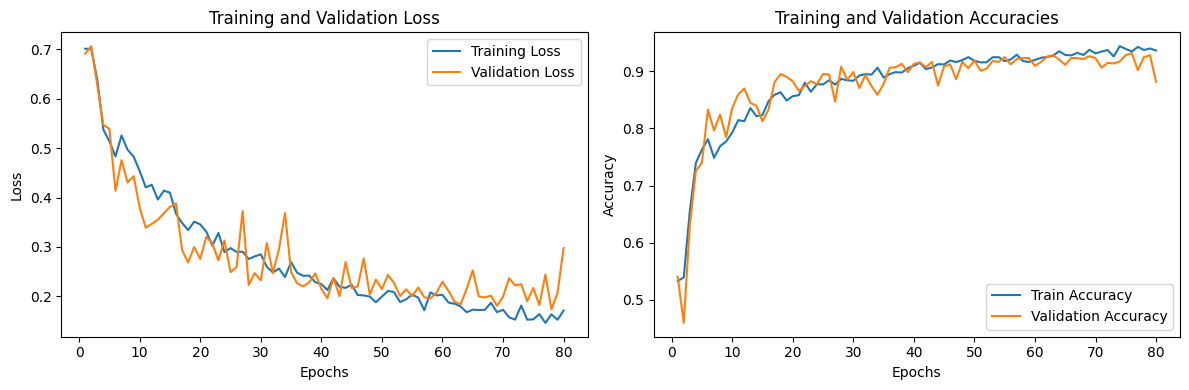

In [7]:
#Retrieve training and validation losses
loss=history.history['loss']
val_loss=history.history['val_loss']

#Retrieve training and validation accuracies
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

# Plot validation loss against epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies against epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()